# Statistical Learning - Unsupervised Learning

---

## Contents

### [Principal Component Analysis](#pca)
   - [What Are Principal Components?](#what-are-princ-comp)
   - [Explained Variability](#explained-variability)
   

### [K-Means Clustering](#kmeans)


### [Hierarchical Clustering](#hierarchical-clustering)

---

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
import seaborn as sns

from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from itertools import combinations

np.set_printoptions(suppress=True)
%matplotlib inline
plt.style.use("fivethirtyeight")

---

## Utilities

In [2]:
def get_pca_loadings(df):
    X = pd.DataFrame(scale(df), index = df.index, columns = df.columns)
    return pd.DataFrame(PCA().fit(X).components_.T,
                        index = df.columns,
                        columns = [f"V{n}" for n in range(1, len(df.columns) + 1)])

In [3]:
def get_pca_df(df):
    X = pd.DataFrame(scale(df), index = df.index, columns = df.columns)
    pca = PCA()
    pca_columns = [f"PC{n}" for n in range(1, len(df.columns) + 1)]
    pca_df = pd.DataFrame(pca.fit_transform(X),
                          index = X.index,
                          columns = pca_columns)
    return pca, pca_df

In [4]:
def plot_pca_two_pc(pca_loadings, pca_df, figsize = (10, 6), pad = 0.5):
    with plt.style.context("default"):
        fig, ax_1 = plt.subplots(figsize = figsize)

        ax_1.set_xlim(np.min(pca_df.PC1) - pad, np.max(pca_df.PC1) + pad)
        ax_1.set_ylim(np.min(pca_df.PC2) - pad, np.max(pca_df.PC2) + pad)

        for i in pca_df.index:
            ax_1.annotate(i, (pca_df.PC1.loc[i], -pca_df.PC2.loc[i]), fontsize = 8)

        ax_2 = ax_1.twinx().twiny()
        ax_2.set_ylim(-1, 1)
        ax_2.set_xlim(-1, 1)
        for i in pca_loadings[["V1", "V2"]].index:
            ax_2.annotate(i, (pca_loadings.V1.loc[i], -pca_loadings.V2.loc[i]),
                          fontsize = 16, color = "coral")
            ax_2.arrow(0, 0, pca_loadings.V1.loc[i], -pca_loadings.V2.loc[i],
                       color = "coral", alpha = 0.5)
            
        ax_2.set_xlabel("Principal Component Loading Vectors", color = "coral")
        ax_1.set_xlabel("First Principal Component")
        ax_1.set_ylabel("Second Principal Component")
        plt.grid(False)
        plt.show()

In [5]:
def pca_scree_plot(pca):
    fig, ax = plt.subplots(figsize = (8, 4))
    plt.plot(np.arange(1, pca.n_components_ + 1),
             pca.explained_variance_ratio_, "-o",
             label = "Individual PC")
    
    plt.plot(np.arange(1, pca.n_components_ + 1),
             np.cumsum(pca.explained_variance_ratio_), "-s",
             label = "Cumulative")
    plt.ylabel("Proportion of Variance Explained")
    plt.xlabel("Principal Component")
    plt.legend(loc = 2, fontsize = 12)
    plt.xticks(np.arange(1, pca.n_components_ + 1))
    plt.show()

In [6]:
def plot_kmeans(model, X):
    fig, ax = plt.subplots(figsize = (8, 4))
    ax.scatter(X[:, 0], X[:, 1], c = model.labels_,
               s = 100, cmap = "coolwarm",
               edgecolor = "k", linewidth = 1)
    ax.scatter(model.cluster_centers_[:, 0],
               model.cluster_centers_[:, 1],
               c = "k", marker = "x", s = 500, linewidth = 2)
    plt.show()

---

## Datasets

In [7]:
usa = pd.read_csv("data/usarrests.csv", index_col = 0)
usa.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


---

<a id="pca"></a>
# Principal Component Analysis

Il concetto di *principal component* è utilizzato principalmente in scenari in cui sono presenti un gran numero di predittori correlati, a partire dai quali è possibile costruire un insieme di cardinalità inferiore di predittori che riescono a spiegare la quasi totalità della variabilità dei dati originali.

Le *principal component directions* sono quelle direzioni del *feature space* lungo le quali i dati sono altamente variabili e, allo stesso tempo, definiscono dei sottospazi che risultano essere i più vicini possibili alla *data cloud*.

La *PCA* può essere definita come il processo attraverso il quale sono calcolati i *principal components*.

---

<a id="what-are-princ-comp"></a>
## What Are Principal Components?

Supponiamo di avere a disposizione un dataset di cardinalità $n$ con $p$ predittori.

Vogliamo individuare una rappresentazione a bassa dimensionalità di questi dati che sia in grado di catturarne il maggior contenuto informativo possibile.

L'idea di fondo è che non tutte queste $p$ dimensioni sono ugualmente interessanti, dove una dimensione è reputata interessante se presenta grande variabilità nel proprio insieme di valori.

La *PCA* ha l'obiettivo di individuare un piccolo numero di dimensioni capaci di descrivere quanta più variabilità possibile nei dati originali, e ognuna di queste dimensioni altro non è che una combinazione lineare dei $p$ predittori originali.

Il *first principal component* di un insieme di predittori $X_1,\dots,X_p$ è definito come la combinazione lineare normalizzata di tali predittori che presenta il maggior valore di varianza.

$$\large Z_1=\phi_{11}X_1+\phi_{21}X_2+\dots+\phi_{p1}X_p$$

Tale *CL* è detta *normalizzata* perché il vincolo principale utilizzato per calcolarla è:

$$\large \sum_{j=1}^{p}\phi_{j1}^2=1$$

Gli elementi $\phi_{11},\dots,\phi_{p1}$ sono detti **loadings** del *first principal component*, e insieme formano il cosiddetto **principal component loading vector**: $\phi_1=\left(\phi_{11},\dots,\phi_{p1}\right)^T$

Dato un dataset $X$ di dimensione $n\times p$, quindi, come possiamo calcolare il *first principal component*? Siccome ci interessa solo la varianza, dobbiamo imporre che ciascuno dei predittori sia centrato per avere media nulla; fatto ciò, dobbiamo risolvere il seguente problema di ottimizzazione:

$$\large maximize \left\{\frac{1}{n}\sum_{i=1}^{n}\left(
\sum_{j=1}^{p}\phi_{j1}x_{ij}\right)^2
\right\}$$

$$\large \text{subject to}\;\;\sum_{j=1}^{p}\phi_{j1}^2=1$$

All'interno della parentesi tonda non abbiamo altro che:

$$\large z_{i1}=\phi_{11}x_{i1}+\phi_{21}x_{i2}+\dots+\phi_{p1}x_{ip}$$

Si tratta della combinazione lineare tipica del *principal component*, ma calcolata solo sull'osservazione $i$-esima. I valori $z_{11},z_{21},\dots,z_{n1}$ prendono il nome di **scores** del *first principal component*.

Notiamo anche come, nella formula di varianza del problema di massimizzazione, sia stato omesso il valore medio in quanto assunto nullo per definizione.

C'è un'interessante intepretazione geometrica per il *first principal component*: il *loading vector* $\phi_1=\left(\phi_{11},\dots,\phi_{p1}\right)^T$ definisce la direzione del *feature space* lungo la quale i dati variano maggiormente; se proiettiamo gli $n$ *data points* $x_1,\dots,x_n$ lungo questa direzione, notiamo che i valori di tali proiezioni sono esattamente i *principal component scores* $z_{11},\dots,z_{n1}$!

<img src="imgs/pcr-simple.PNG"/>

Il secondo *principal component* è la combinazione lineare dei predittori non correlata con $Z_1$ che massimizza il valore risultante di varianza.

Si è dimostrato che il vincolo di non correlazione corrisponde a scegliere come $\phi_2$ una dimensione ortogonale a $\phi_1$.

Dopo aver trovato i *principal components* d'interesse, possiamo plottarli l'uno contro l'altro per produrre delle visualizzazioni dei dati a bassa dimensionalità; ad esempio, potremmo plottare gli *score* $Z_1$ contro $Z_2$, e poi $Z_1$ contro $Z_3$, e così via.

<br>

Applichiamo la *PCA* al dataset *USArrests*, dove troviamo per ognuno dei 50 stati americani il numero di arresti per 100K abitanti, opportunamente categorizzati in *Assault*, *Murder* e *Rape*. Si tiene traccia, inoltre* di *UrbanPop*, cioè la percentuale di popolazione in ciascun stato che vive in aree urbane.

Calcoliamo i *loading vectors*:

In [8]:
pca_loadings = get_pca_loadings(usa)
pca_loadings

,V1,V2,V3,V4
Murder,0.535899,0.418181,-0.341233,0.649228
Assault,0.583184,0.187986,-0.268148,-0.743407
UrbanPop,0.278191,-0.872806,-0.378016,0.133878
Rape,0.543432,-0.167319,0.817778,0.089024


Notiamo come il *first principal component* applichi un peso più o meno uguale sui tre tipi di arresto e un peso minore per *UrbanPop*. Questo vuol dire che il *PC1* rappresenta una sorta di misura generalizzata del *rate* di criminalità.

Il secondo componente principale, invece, fa esattamente il contrario: ciò implica che il *PC2* prova a rappresentare il livello di urbanizzazione di uno stato.

Calcoliamo tutti gli *scores*:

In [9]:
__, pca_df = get_pca_df(df = usa)
pca_df.head()

,PC1,PC2,PC3,PC4
Alabama,0.985566,1.133392,-0.444269,0.156267
Alaska,1.950138,1.073213,2.040003,-0.438583
Arizona,1.763164,-0.745957,0.054781,-0.834653
Arkansas,-0.141420,1.119797,0.114574,-0.182811
California,2.523980,-1.542934,0.598557,-0.341996


Plottiamo un **biplot**, che mostra sia i *principal component scores* che i *principal component loadings*:

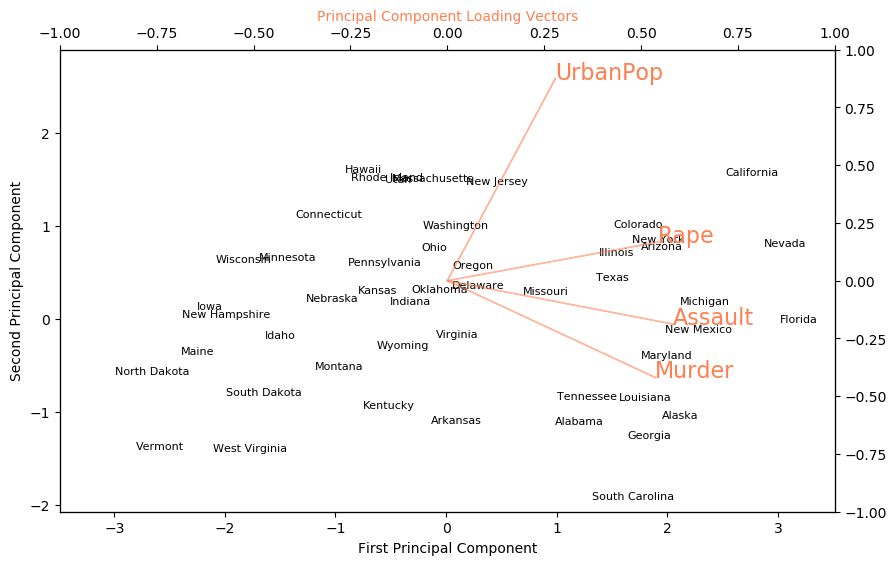

In [10]:
plot_pca_two_pc(pca_loadings, pca_df)

Notiamo come le variabili associate ai crimini siano molto vicine fra loro, mentre *UrbanPop* è più distante: ciò indica che le variabili da crimini sono correlate fra di loro, cioè che gli stati con alti livelli di omicidio presentano anche alti tassi di aggressione e stupro.

Analizzando i dati possiamo affermare che gli stati con ampi *score* positivi per il *PC1* (come California, Nevada e Florida) presentano alta criminalità, mentre quelli con *score* negativi presentano un tasso minore di criminalità. La California presenta uno *score* alto anche per *PC2*, a indicare come gran parte della sua popolazione sia urbana, cosa che ad esempio non è valida per Mississippi.

Infine, gli stati che mostrano valori vicini allo zero per entrambi i componenti sono associati approssimativamente a valori *medi* per criminalità e urbanizzazione.

---

<a id="explained-variability"></a>
## Explained Variability

Nel plottare le osservazioni del dataset *USArrests* in sole due dimensioni, una domanda sorge spontanea? Quanto del contenuto informativo totale perdiamo proiettando i dati su due soli *principal components*? In altre parole, quanta variabilità dei dati non è contenuta nei primi due componenti principali?

Più in generale, siamo interessati a conoscere la cosiddetta **proportion of variance explained** (*PVE*) per ciascun *principal component*.

La **total variance** di un dataset (assumendo che tutte le variabili abbiano tutte media nulla) è così definita:

$$\large \sum_{j=1}^{p}Var(X_j)=\sum_{j=1}^{p}\frac{1}{n}\sum_{i=1}^{n}x_{ij}^2$$

La varianza *explained* dall'$m$-esimo componente principale, invece, è pari a:

$$\large \frac{1}{n}\sum_{i=1}^{n}z_{im}^2=
\frac{1}{n}\sum_{i=1}^{n}\left(
\sum_{j=1}^{p}\phi_{jm}x_{ij}\right)^2$$

Di conseguenza la *PVE* dell'$m$-esimo componente principale può essere calcolata come:

$$\large PVE_m=\frac{\sum_{i=1}^{n}\left(\sum_{j=1}^{p}
\phi_{jm}x_{ij}\right)^2}
{\sum_{j=1}^{p}\sum_{i=1}^{n}x_{ij}^2}$$

Ricordiamo che il numero totale di componenti principali è sempre pari a:

$$\large \#PC=min(n-1,p)$$

Calcoliamo le *PVE* per l'esempio di *USArrests*:

In [11]:
pca, __ = get_pca_df(df = usa)

In [12]:
pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

I primi due componenti principali spiegano quasi l'87% della variabilità totale nei dati, quindi il plot bidimensionale rappresenta un buon riassunto del contenuto informativo totale.

In [13]:
np.sum(pca.explained_variance_ratio_[:2])

0.8675016829223339

Creiamo uno **scree plot** per avere una visualizzazione più compatta:

In [14]:
pca.n_components_

4

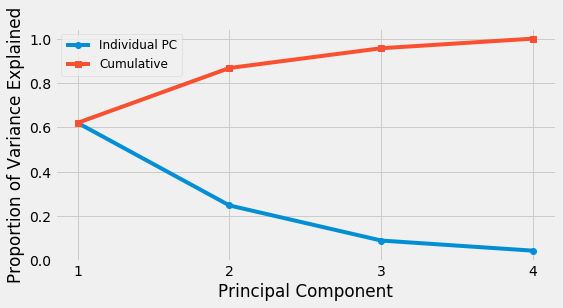

In [15]:
pca_scree_plot(pca)

---

<a id="kmeans"></a>
# K-Means Clustering

Il *K-Means* è una tecnica semplice ed elegante per partizionare un dataset in $K$ cluster distinti. Il processo di assegnazione in cluster si basa su due vincoli fondamentali:

- Ogni osservazione appartiene ad almeno uno dei $K$ cluster
- Nessuna osservazione appartiene a più di un cluster

L'idea di fondo del *K-Means* è che un buon algoritmo di clustering è quello che presenta la minima **within-cluster variation** possibile, che rappresenta una misura di quanto le osservazioni incluse in uno stesso cluster differiscano tra loro.

L'obiettivo del *K-Means*, quindi, è partizionare le osservazioni in $K$ cluster così da minimizzare la *within-cluster variation* sommata per tutti i cluster. La definizione di questa particolare metrica si basa, ancora una volta, sulla distanza euclidea quadratica:

$$\large W(C_k)=\frac{1}{|C_k|}\sum_{a,b\in C_k}\sum_{j=1}^{p}
\left(x_{aj}-x_{bj}\right)^2$$

Dove $|C_k|$ è il numero di osservazioni contenute nel $k$-esimo cluster.

A questo punto possiamo definire formalmente il problema di ottimizzazione che caratterizza il *K-Means*:

$$\large minimize\left\{ \sum_{k=1}^{K}\frac{1}{|C_k|}
\sum_{a,b\in C_k}\sum_{j=1}^{p}\left(x_{aj}-x_{bj}\right)^2\right\}$$

Risolvere questo problema non è immediato, dato che esistono circa $K^n$ possibili modi per partizionare $n$ osservazioni in $K$ cluster.

Esiste però un algoritmo molto semplice capace di restituire un *local optimum* del problema, cioè una soluzione sempre accettabile e, in certi casi, molto efficace:

- Si assegna a ciascuna osservazione, in maniera randomica, uno dei $K$ cluster a disposizione.


- Si iterano i seguenti due sotto-step fin quando la fase di assegnazione dei cluster non causa più modifiche nella struttura:
    
   - Per ogni cluster, si calcola il suo **centroid**: si tratta del vettore che contiene i valori medi delle $p$ features calcolato a partire solo dalle osservazioni presenti nel cluster in questione.
   - Si assegnano le osservazioni al cluster ad esse più vicino, dove la misura di vicinanza è rappresentata dalla distanza delle singole osservazioni rispetto ai *centroid* appena calcolati.

<img src="imgs/kmeans.PNG"/>

Il *K-Means* deriva il suo nome proprio da quest'ultimo passaggio, in cui i centroidi sono calcolati come il punto medio delle osservazioni di ciascun cluster.

Siccome questo algoritmo, per via di com'è costruito, è capace solo di fornire un *local optimum* per il problema, la qualità dei risultati dipenderà dall'inizializzazione randomica dei cluster del primo step.

Un approccio comune, infatti, consiste nell'eseguire l'intero algoritmo più volte, scegliendo come modello di clustering finale quello che restituisce la soluzione migliore.

<br>

Facciamo un esempio con un dataset fittizio:

In [16]:
np.random.seed(2)
X = np.random.standard_normal((50, 2))
X[:25, 0] = X[:25, 0] + 3
X[:25, 1] = X[:25, 1] - 4

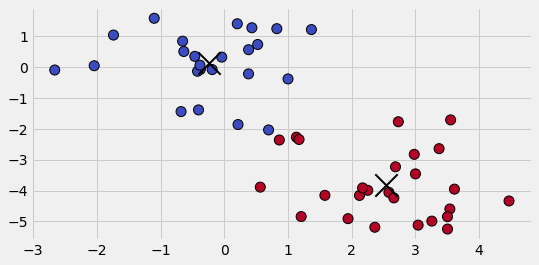

In [17]:
model = KMeans(n_clusters = 2, n_init = 20)
model.fit(X)

plot_kmeans(model, X)

Nella variabile *inertia_* troviamo la somma delle distanze delle osservazioni dal centroide più vicino.

In [18]:
model.inertia_

99.30578397914685

Proviamo con tre clusters:

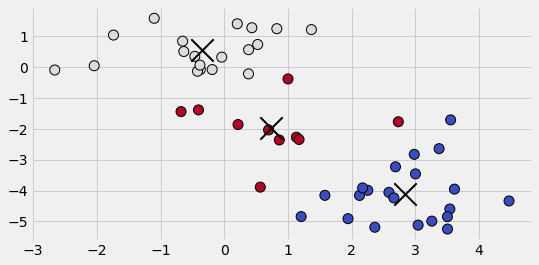

In [19]:
model = KMeans(n_clusters = 3, n_init = 20)
model.fit(X)

plot_kmeans(model, X)

---

<a id="hierarchical-clustering"></a>
# Hierarchical Clustering

Lo *hierarchical clustering* è un approccio alternativo al *K-Means* che non necessita di una dichiarazione a priori del numero di cluster da costruire nel modello finale. Inoltre, esso fornisce un'utile rappresentazione grafica *tree-based*, chiamata **dendogram**, che può essere utilizzata ai fini della *model interpretability*.

Supponiamo di avere a disposizione 45 osservazioni, e di dover individuare un loro corretto partizionamento in cluster.

<img src="imgs/dendogram.PNG"/>

Ogni foglia del *dendogram* rappresenta una singola osservazione; man mano che ci si sposta verso la radice dell'albero, tali osservazioni vengono fuse insieme a formare dei *branches*. I *branches* corrispondono a insiemi di osservazioni molto simili tra loro.

Se le fusioni si verificano molto in basso, il grado di similarità è molto alto, mentre se si verificano in prossimità della radice, il grado di similarità è minore.

L'asse delle ordinate del *dendogram* svolge precisamente questo ruolo: misura l'entità della differenza fra due osservazioni o fra due gruppi di osservazioni.

Per identificare dei cluster a partire da un *dendogram*, è necessario tracciare delle rette orizzontali che ne taglino l'intera superficie. I cluster sono definiti come i gruppi isolati di osservazioni che si trovano al di sotto del taglio effettuato.

Analizzando il *dendogram* di esempio, notiamo come applicare un taglio ad altezza 9 porti alla costruzione di due soli cluster, mentre un taglio ad altezza 5 ne produca tre.

L'altezza del taglio assume lo stesso ruolo dell'iperparametro $K$ nel *K-Means*, con la differenza che in questo caso ci basta costruire un solo *dendogram* e scegliere a posteriori il numero di cluster da definire.

Il termine *hierarchical* associato all'algoritmo fa riferimento al fatto che i cluster ottenuti dal taglio orizzontale del *dendogram* ad una certa altezza sono inevitabilmente annidati rispetto ai cluster che otterremmo se tagliassimo lo stesso *dendogram* ad un'altezza superiore!

In determinati scenari, però, l'assunzione di questa struttura gerarchica non è realistica. Ad esempio, supponiamo di disporre di un dataset che presenti uno split 50/50 fra uomini e donne, ed un'ulteriore divisione in americani, giapponesi e francesi. Possiamo immaginare uno scenario in cui la divisione migliore in due cluster sia in grado di dividere le osservazioni per *gender*, mentre la divisione migliore in tre cluster arrivi a separare le osservazione per *nationality*. All'atto pratico, però, i veri cluster non sono annidati, nel senso che la migliore divisione in tre cluster non deriva dal risultato della migliore divisione in due gruppi e dalla successiva divisione di uno di questi due. Questo è uno dei tanti possibili esempi in cui l'*hierarchical clustering* può restituire risultati meno accurati del *K-Means clustering*.

<br>

L'algoritmo di costruzione di un *dendogram* parte dalla definizione di una qualche misura di *dissimilarity* fra le osservazioni. Nella maggior parte dei casi, si tratta della distanza euclidea.

Il processo inizia con ciascuna delle $n$ osservazioni trattate come se appartengano ad un proprio cluster personale. I due cluster più simili fra loro sono fusi, ottenendo così $n-1$ cluster totali. I successivi due cluster più simili fra loro sono fusi, ottenendo così $n-2$ cluster totali e così via, fin quando tutte le osservazioni non appartengono ad un solo cluster, cioè la radice dell'albero.

Sorge spontaneo un dubbio: come si misura la similarità fra cluster che contengono un diverso numero di osservazioni? Si introduce il concetto di **linkage**, che descrive le modalità di misurazione di similarità fra gruppi di osservazioni e non fra singole osservazioni. Possiamo scegliere fra quattro tipologie:

- **Complete**: si calcolano tutte le possibili *dissimilarities* fra le osservazioni del primo cluster e le osservazioni del secondo; si utilizza come metrica unificata la più grande fra di esse.


- **Single**: si calcolano tutte le possibili *dissimilarities* fra le osservazioni del primo cluster e le osservazioni del secondo; si utilizza come metrica unificata la più piccola fra di esse.



- **Average**: si calcolano tutte le possibili *dissimilarities* fra le osservazioni del primo cluster e le osservazioni del secondo; si utilizza come metrica unificata il loro valor medio.



- **Centroid**: si calcola il centroide del primo cluster ed il centroide del secondo cluster; si utilizza come me trica unificata la *dissimilarity* fra i due centroidi.

Si tende a preferire *average* e *complete* rispetto a *single*, dato che forniscono *dendograms* più bilanciati. Il *centroid linking*, invece, è il meno utilizzato perché può soffrire del fenomeno di *inversion*: due cluster possono essere fusi ad un'altezza inferiore rispetto alle altezze dei singoli cluster prima della fusione.

<br>

Facciamo un esempio con lo stesso dataset fittizio usato per il *K-Means*:

In [20]:
np.random.seed(2)
X = np.random.standard_normal((50, 2))
X[:25, 0] = X[:25, 0] + 3
X[:25, 1] = X[:25, 1] - 4

Text(0.5, 1.0, 'Single Linkage')

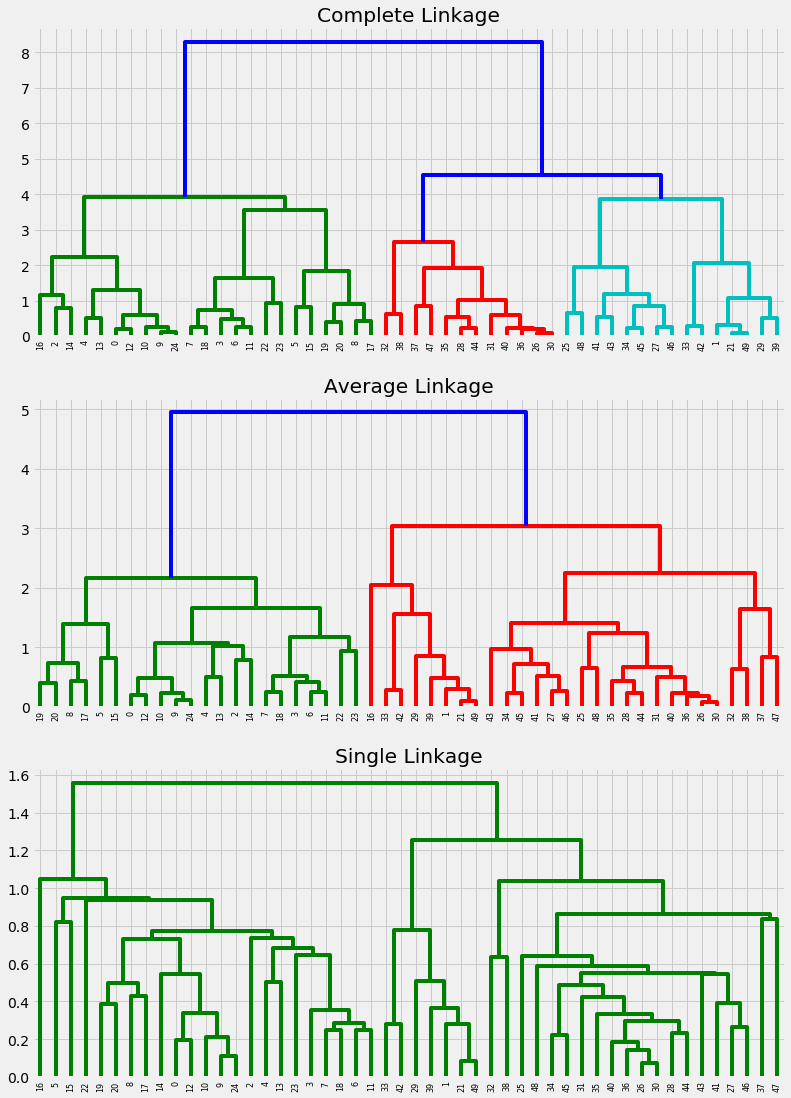

In [21]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(3, 1, figsize = (12, 18))

for linkage, cluster, ax in zip([hierarchy.complete(X), hierarchy.average(X), hierarchy.single(X)],
                                ["model_1","model_2","model_3"],
                                [ax_1, ax_2, ax_3]):
    model = hierarchy.dendrogram(linkage, ax = ax, color_threshold = 4)

ax_1.set_title("Complete Linkage")
ax_2.set_title("Average Linkage")
ax_3.set_title("Single Linkage")

---